In [1]:
import pycisTopic
%load_ext nb_black
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pickle
import pandas as pd
import os

<IPython.core.display.Javascript object>

In [2]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/full_4_merged


<IPython.core.display.Javascript object>

In [3]:
wdir = '/lustre1/project/stg_00090/scatac_benchmark/full_4_merged'
os.chdir( wdir )

<IPython.core.display.Javascript object>

In [4]:
# create output directory:
f_final_dir = os.path.join(wdir, 'downstream_analysis')
if not os.path.exists(f_final_dir):
    os.makedirs(f_final_dir)
    
# create output directory:
for tmpdir in ["binarized_topics", "DARs", "HVRs", "imputed_acc_objs"]:
    tomake = os.path.join(f_final_dir, tmpdir)
    if not os.path.exists(tomake):
        os.makedirs(tomake)
    


<IPython.core.display.Javascript object>

In [5]:
import glob

<IPython.core.display.Javascript object>

## Save/load cisTopic objects

In [6]:
cto_consensus_paths = sorted(glob.glob(f'cistopic_objects_master/*dimreduc.consensus.pkl'))
cistopic_obj_path_dict = {x.split('/')[-1].split(f'__')[0]:x for x in cto_consensus_paths}
cistopic_obj_path_dict

{'master_all_1.FULL': 'cistopic_objects_master/master_all_1.FULL__cto.scrublet0-4.fmx.singlets.model_60topics.dimreduc.consensus.pkl'}

<IPython.core.display.Javascript object>

## Topic binarization & QC

In [7]:
from pycisTopic.topic_binarization import binarize_topics
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc
from pycisTopic.utils import fig2img
import matplotlib.pyplot as plt
from pycisTopic.topic_qc import topic_annotation
from pycisTopic.diff_features import *
from pycisTopic.clust_vis import plot_imputed_features
import numpy as np
import copy

<IPython.core.display.Javascript object>

### Binarize the topic-region distributions

for sample in cistopic_obj_path_dict.keys():
    path = cistopic_obj_path_dict[sample]
    if not os.path.exists(f'downstream_analysis/DARs/{sample}'):
        if os.path.isfile(path):
            print(f"Loading {path}")
            with open(path, 'rb') as f:
                cto = pickle.load(f)

outpath=f"downstream_analysis/imputed_acc_objs/{sample}__imputed_acc_obs.pkl"
if os.path.exists(outpath):
    with open(outpath, 'rb') as f:
        imputed_acc_obj = pickle.load(f)
else:
    print("impute_accessibility")
    imputed_acc_obj = impute_accessibility(
        cto,
        selected_cells=None,
        selected_regions=None,
        scale_factor=10**6
    )

    with open(
        outpath,'wb'
    ) as f:
        pickle.dump(imputed_acc_obj, f, protocol=4)

Loading cistopic_objects_master/master_all_1.FULL__cto.scrublet0-4.fmx.singlets.model_60topics.dimreduc.consensus.pkl


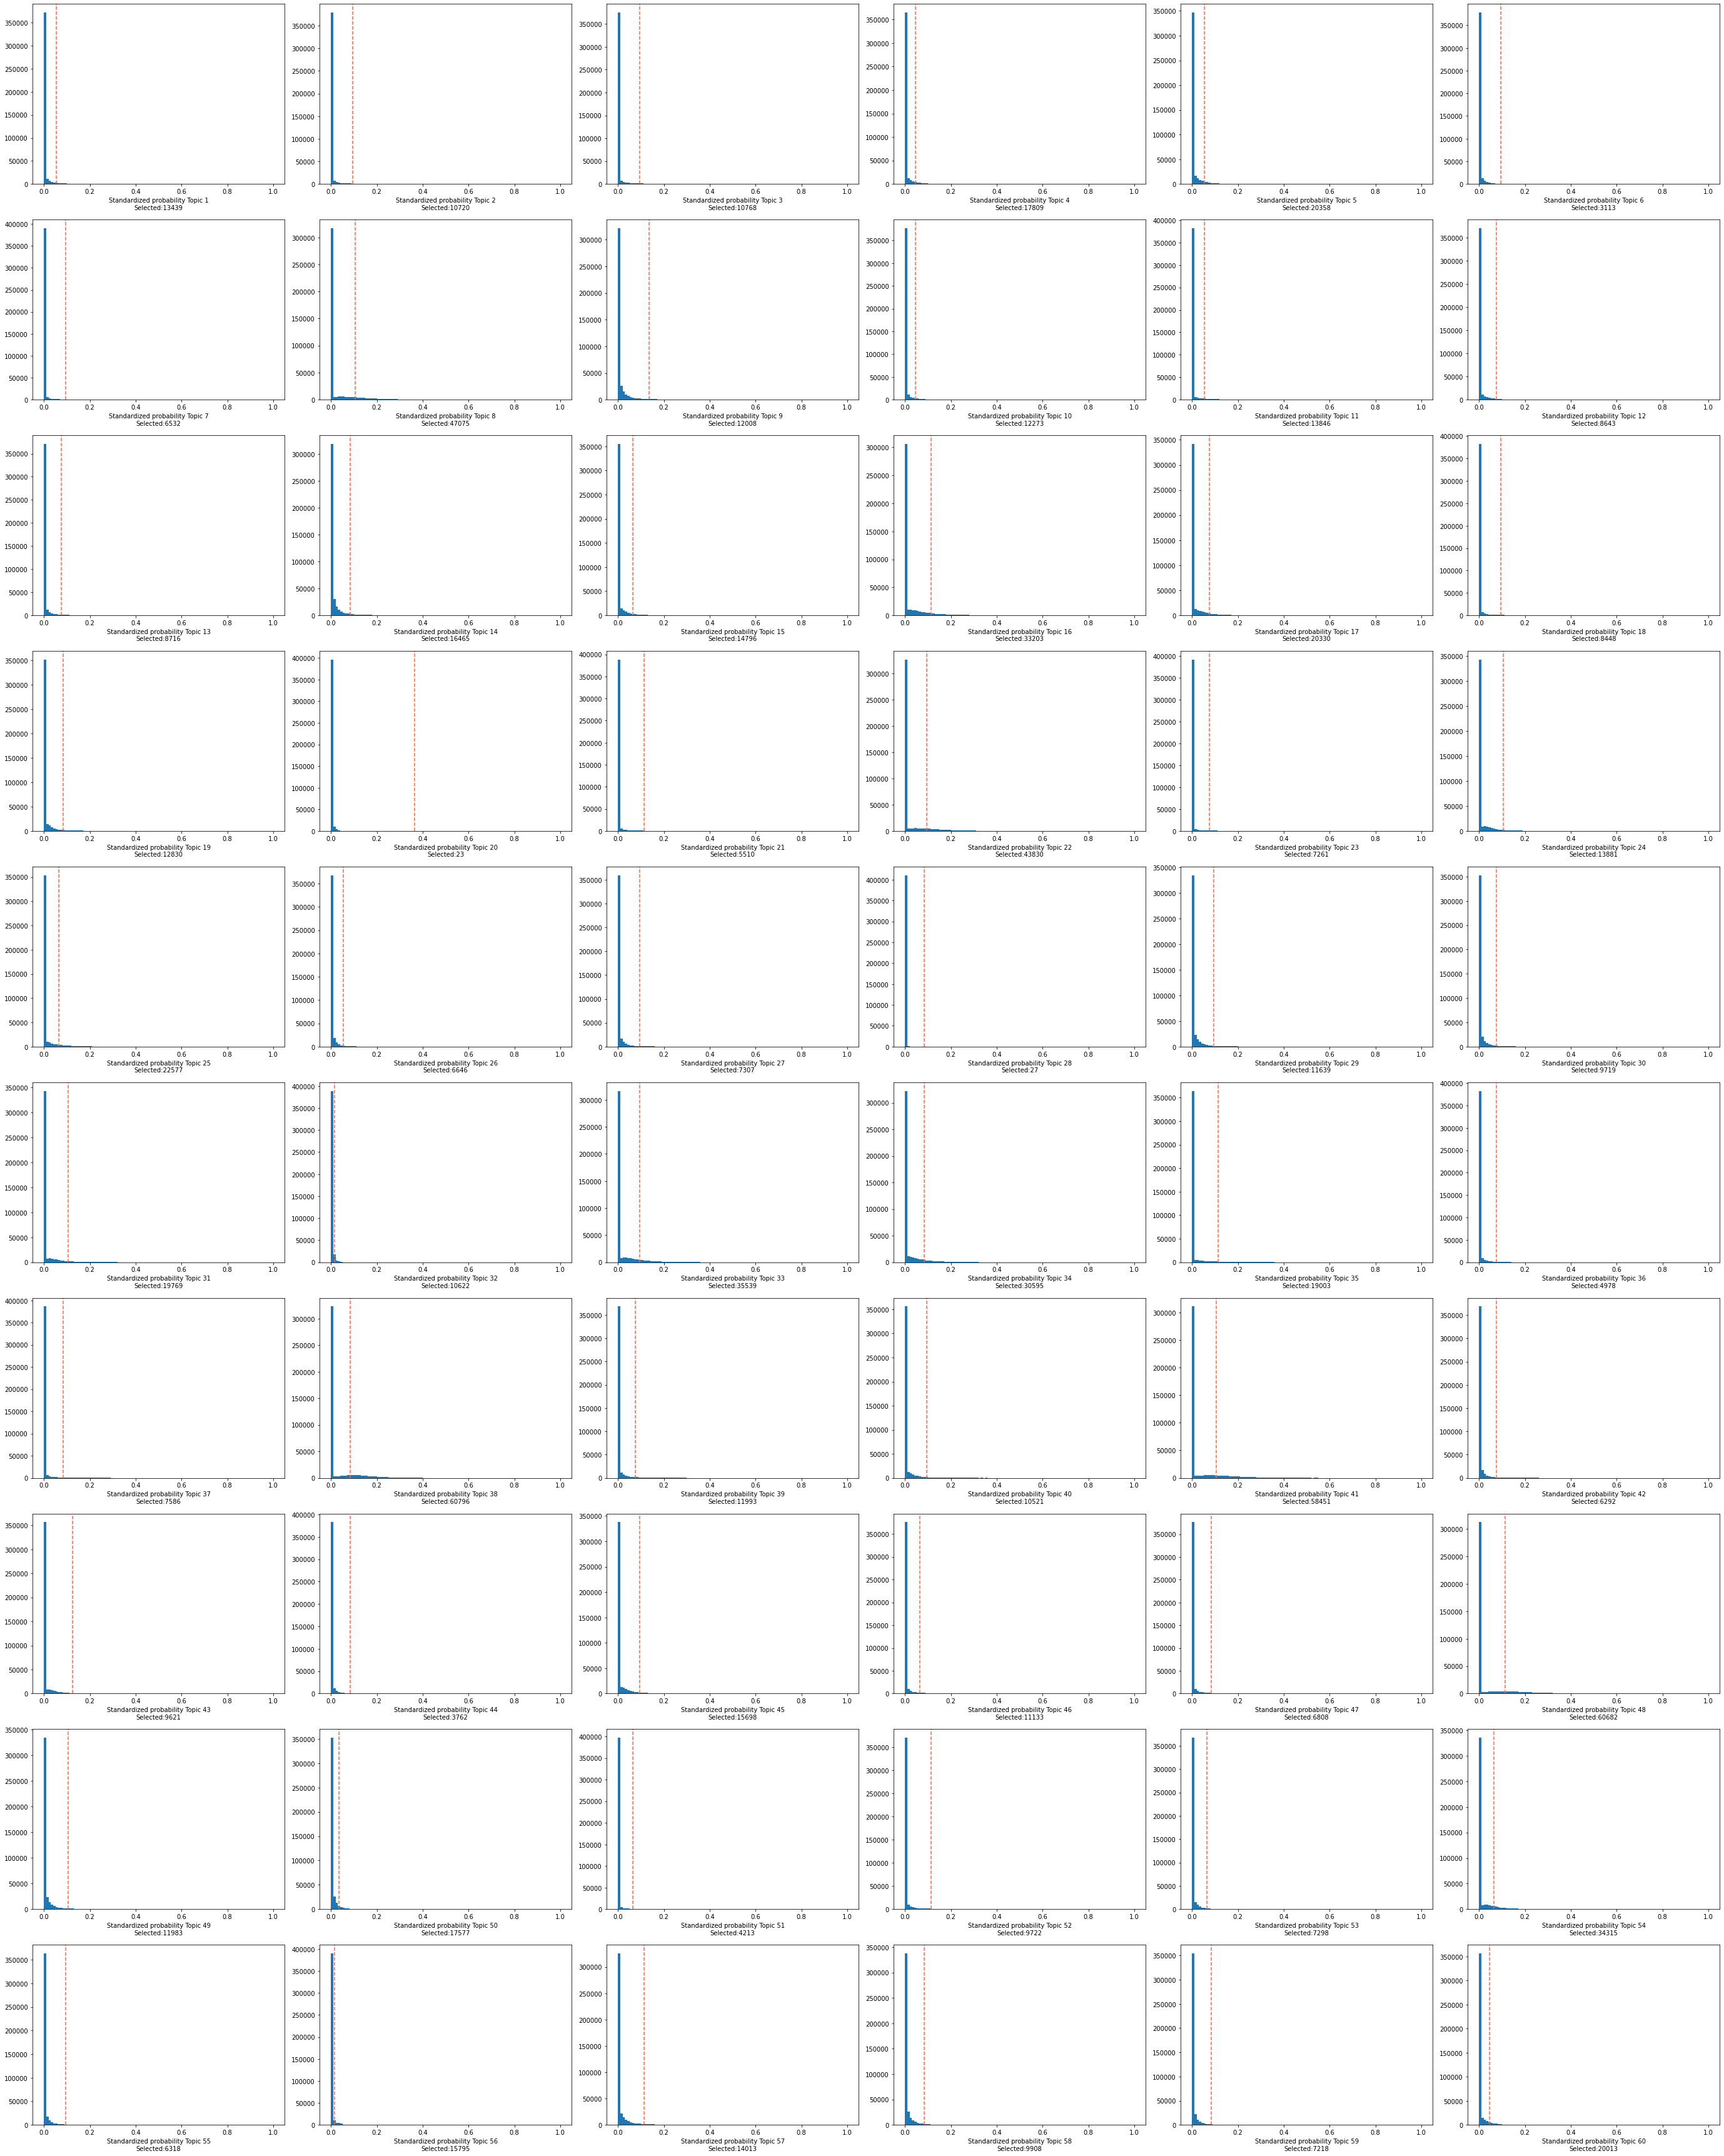

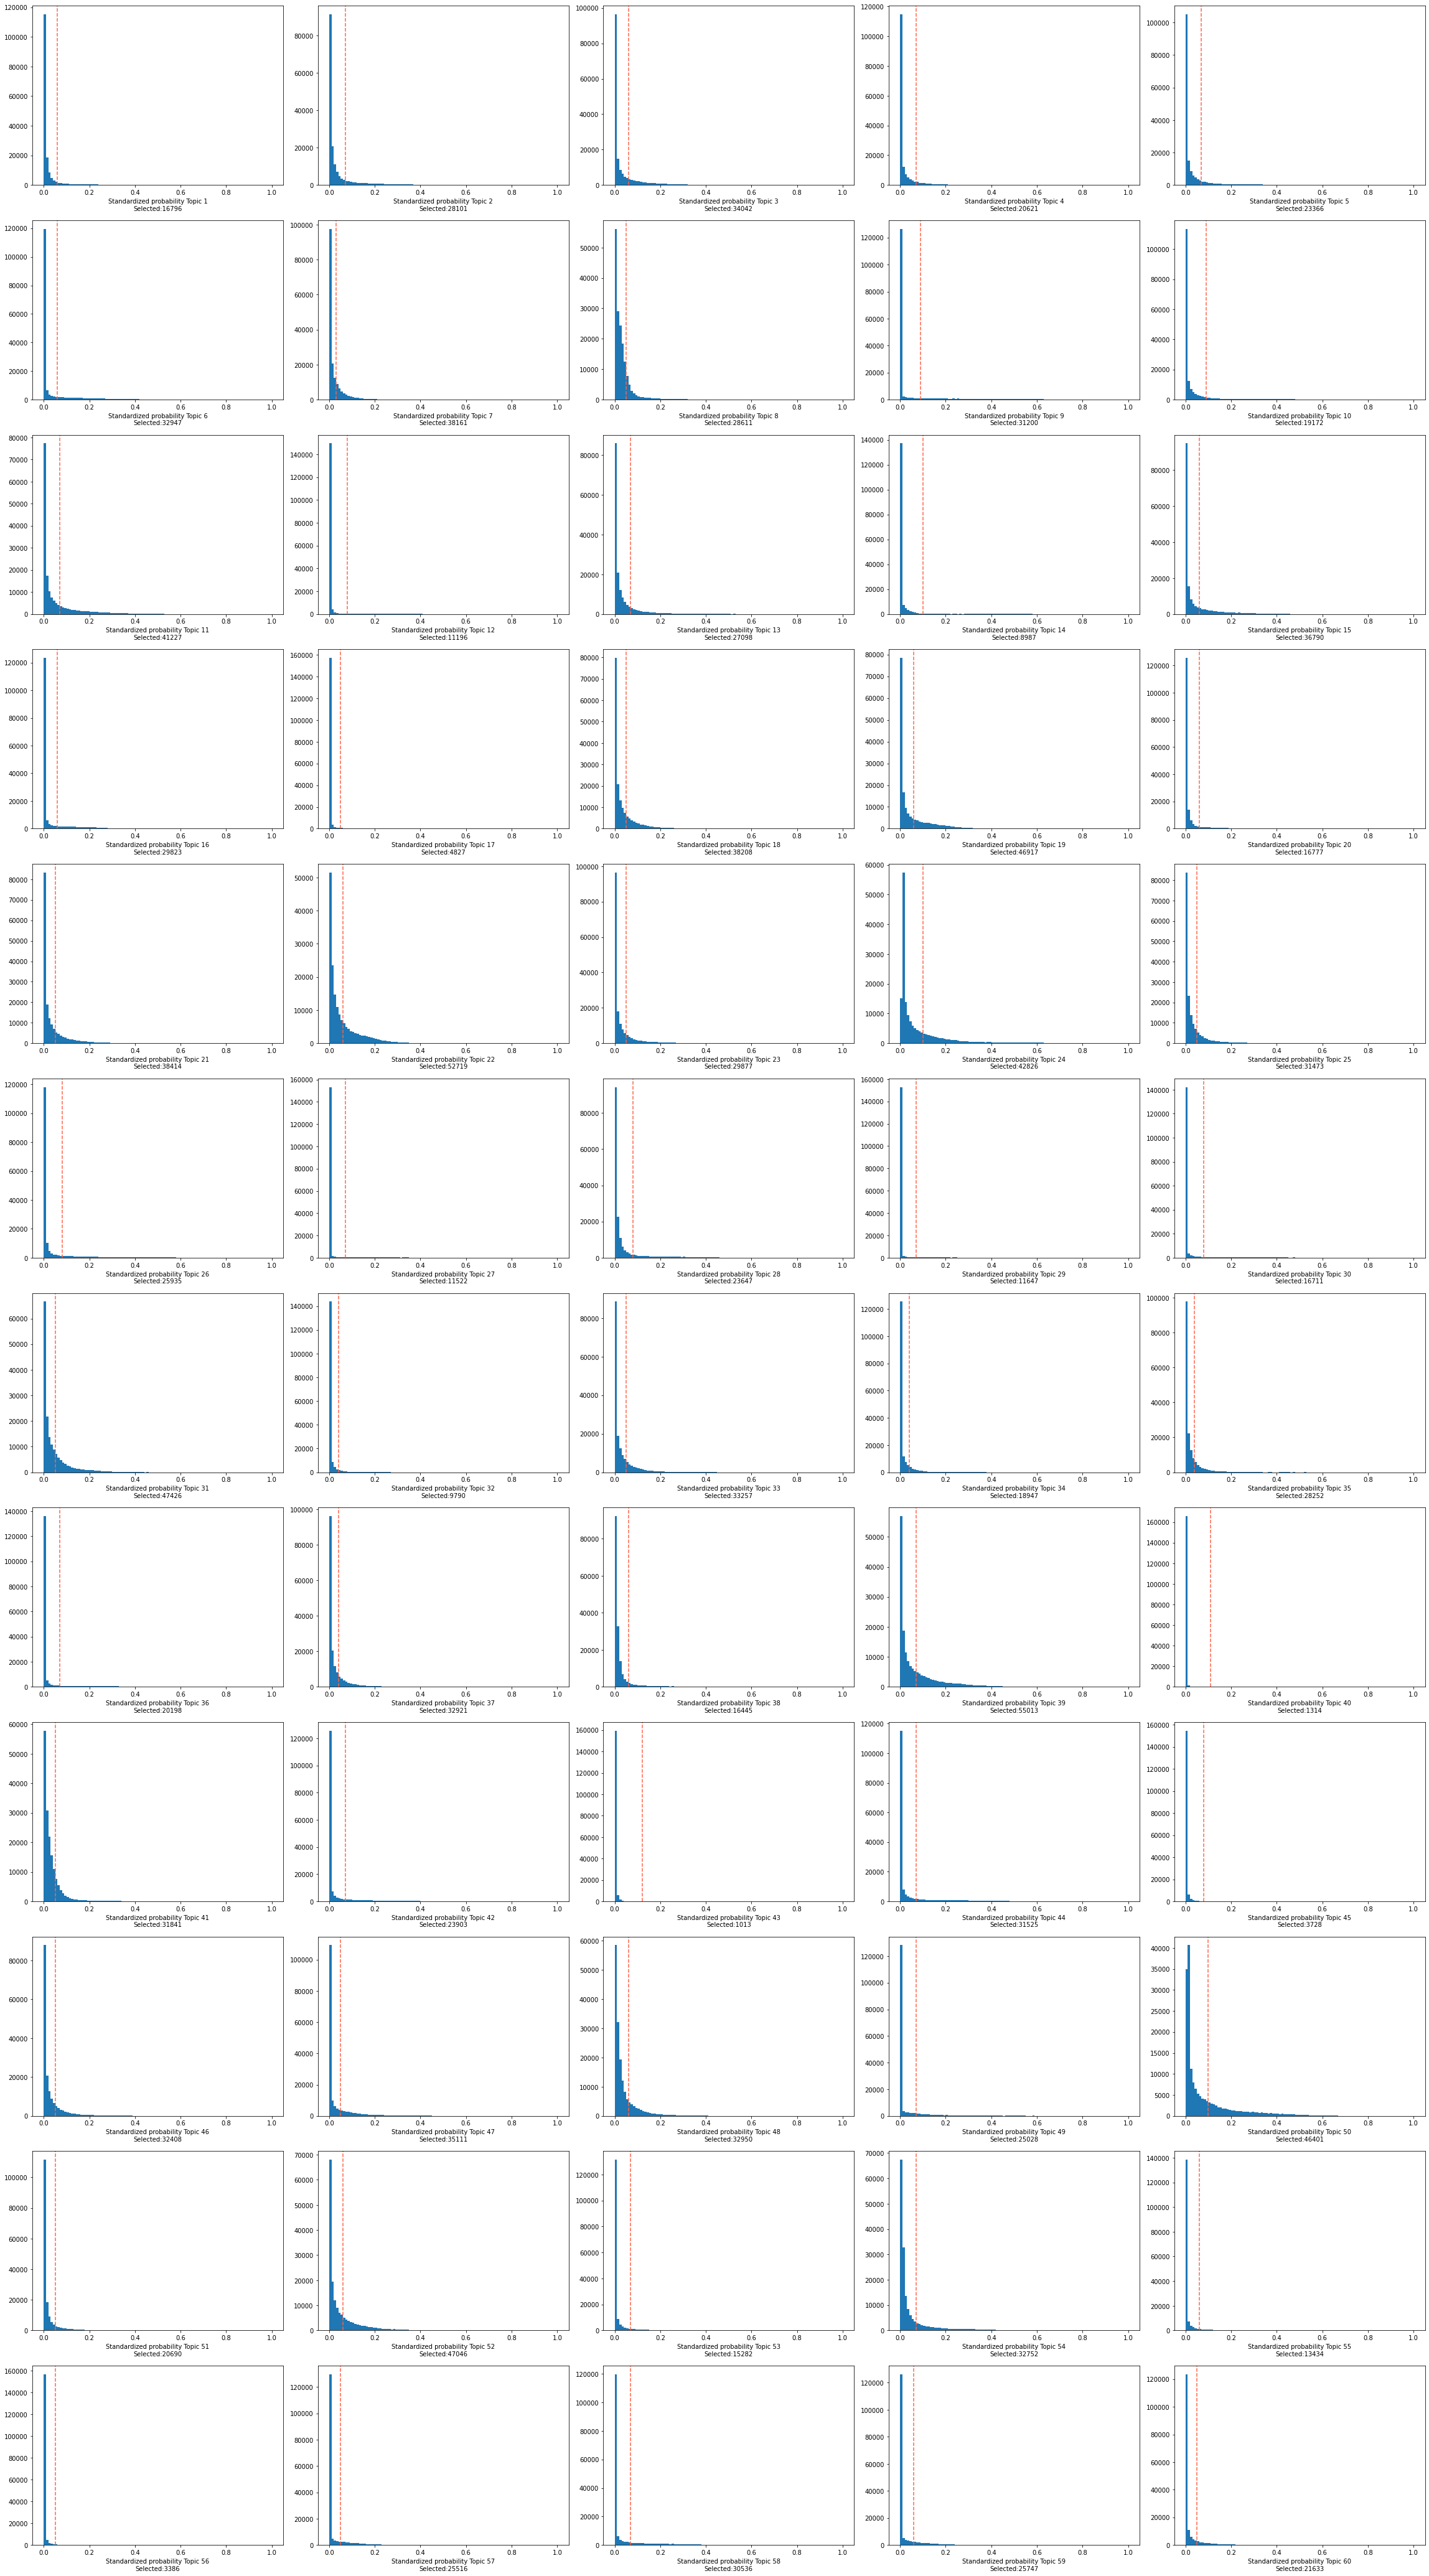

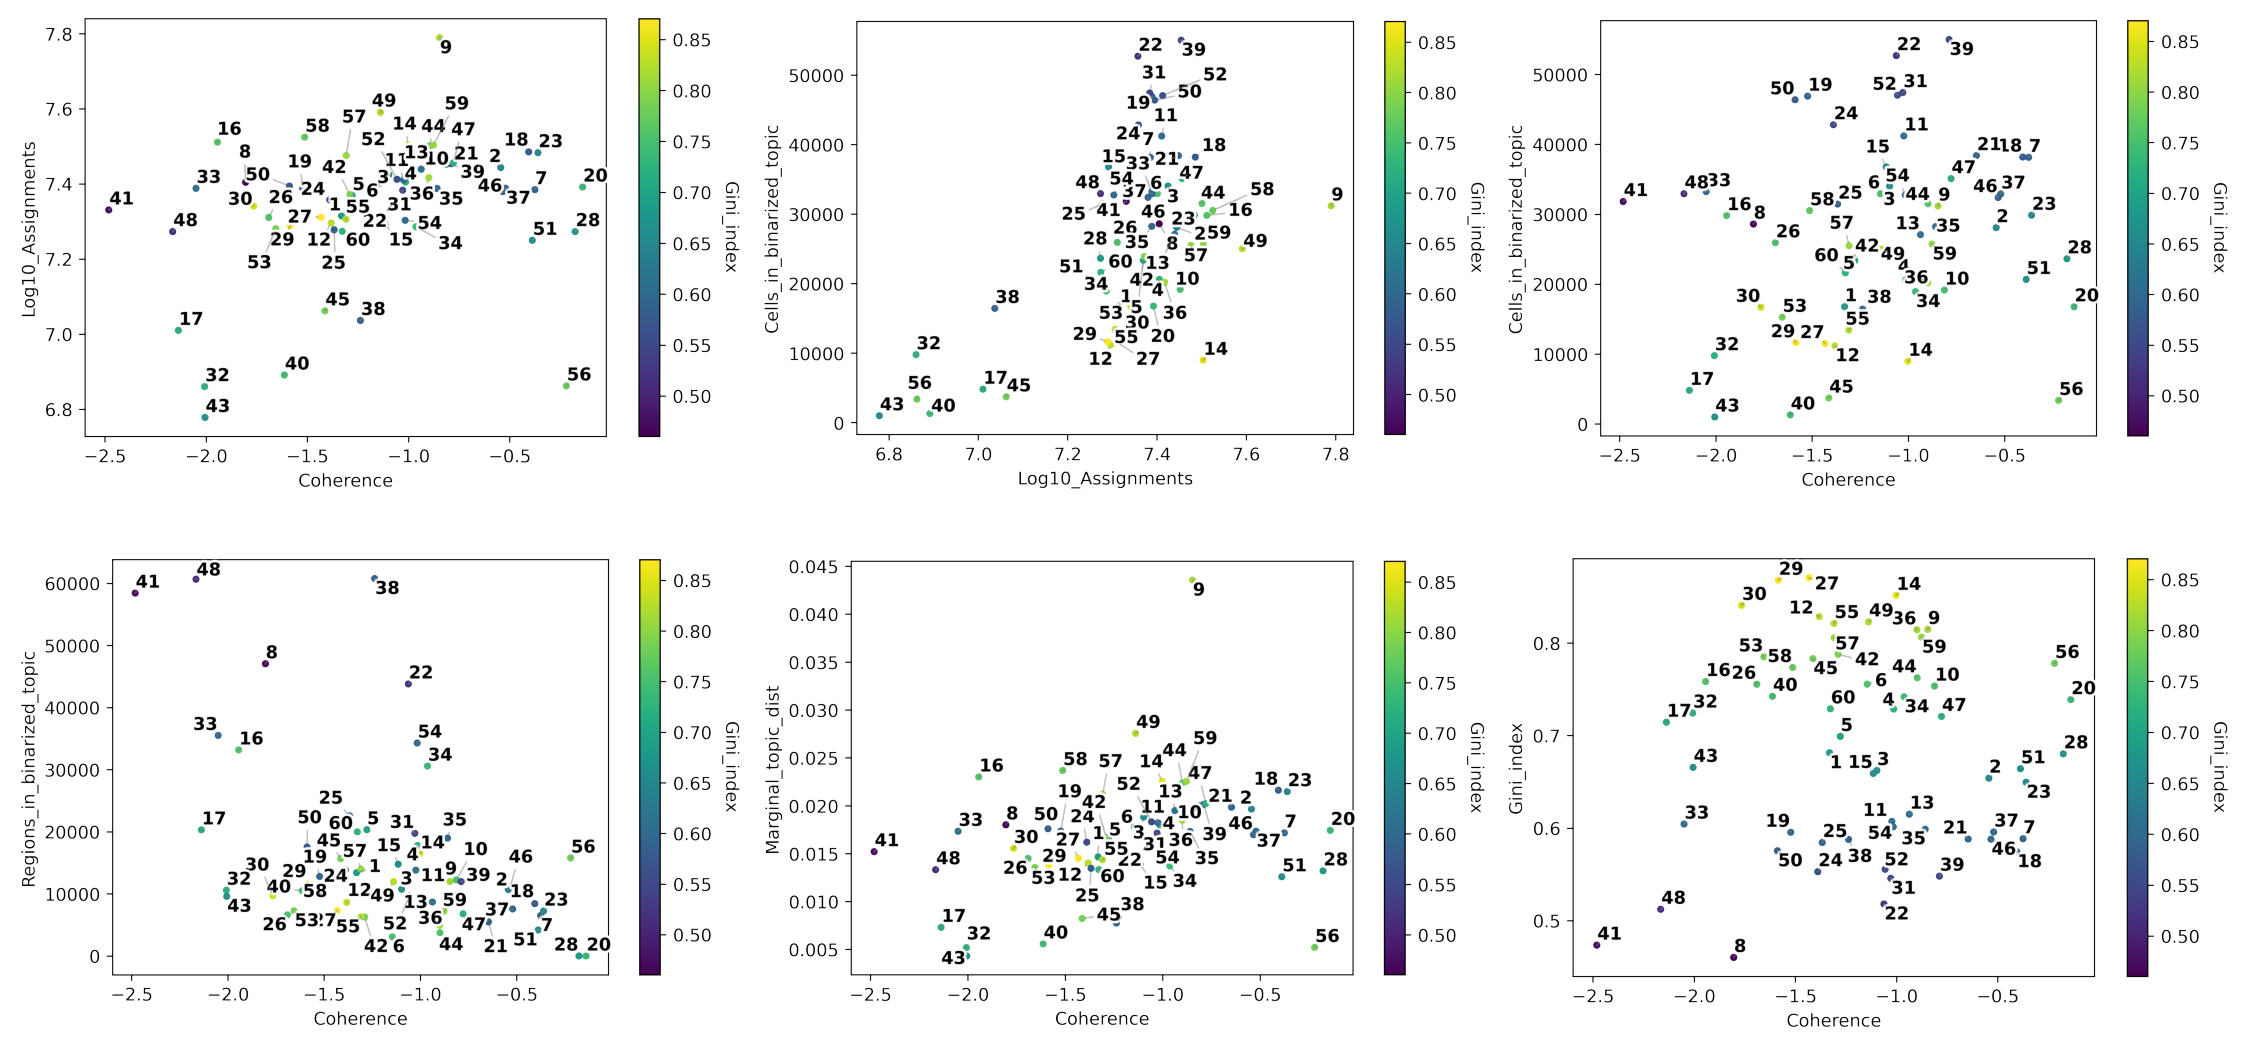

topic annotation
topic_qc_metrics
impute_accessibility
2023-02-20 18:48:44,644 cisTopic     INFO     Imputing drop-outs
2023-02-20 18:51:24,093 cisTopic     INFO     Scaling
2023-02-20 18:53:47,319 cisTopic     INFO     Keep non zero rows
2023-02-20 18:57:43,640 cisTopic     INFO     Imputed accessibility sparsity: 0.6929976213201944
2023-02-20 18:57:43,643 cisTopic     INFO     Create CistopicImputedFeatures object
2023-02-20 18:57:43,644 cisTopic     INFO     Making matrix sparse
2023-02-20 19:18:03,620 cisTopic     INFO     Done!
normalize_scores
2023-02-20 19:22:07,373 cisTopic     INFO     Normalizing imputed data
2023-02-20 19:39:03,463 cisTopic     INFO     Done!


In [ ]:
for sample in cistopic_obj_path_dict.keys():
    path = cistopic_obj_path_dict[sample]
    if not os.path.exists(f'downstream_analysis/DARs/{sample}'):
        if os.path.isfile(path):
            print(f"Loading {path}")
            with open(path, 'rb') as f:
                cto = pickle.load(f)
                
            cto.cell_names = cto.cell_data.index
            if [x.split('-')[0] for x in cto.selected_model.cell_topic.columns] == [x.split('___')[0] for x in list(cto.cell_names)]:
                cto.selected_model.cell_topic.columns =  list(cto.cell_names)
                
            outpath=f"downstream_analysis/binarized_topics/{sample}__topic_region_binarized.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    region_bin_topics = pickle.load(f)
            else:
                region_bin_topics = binarize_topics(
                    cto,
                    method='otsu',
                    ntop=3000,
                    plot=True,
                    num_columns=6,
                    save=f'plots_qc/{sample}__topic_region_binarized.png'
                )

                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(region_bin_topics, f, protocol=4)
                    
            outpath=f"downstream_analysis/binarized_topics/{sample}__cells_topic_binarized.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    binarized_cell_topics = pickle.load(f)
            else:
                binarized_cell_topics = binarize_topics(
                    cto,
                    target='cell',
                    method='li',
                    plot=True,
                    num_columns=5,
                    nbins=100,
                    save=f'plots_qc/{sample}__cells_topic_binarized.png'
                )

                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(binarized_cell_topics, f, protocol=4)

            outpath=f"downstream_analysis/binarized_topics/{sample}__topic_qc.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    topic_qc_metrics = pickle.load(f)
            else:
                topic_qc_metrics = compute_topic_metrics(cto)
                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(topic_qc_metrics, f, protocol=4)

            fig_dict= {
                'CoherenceVSAssignments': plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments',
                                                        var_color='Gini_index', plot=False, return_fig=True),
                'AssignmentsVSCells_in_bin': plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments',
                                                           var_y='Cells_in_binarized_topic', var_color='Gini_index',
                                                           plot=False, return_fig=True),
                'CoherenceVSCells_in_bin': plot_topic_qc(topic_qc_metrics, var_x='Coherence',
                                                         var_y='Cells_in_binarized_topic', var_color='Gini_index',
                                                         plot=False, return_fig=True),
                'CoherenceVSRegions_in_bin': plot_topic_qc(topic_qc_metrics, var_x='Coherence',
                                                           var_y='Regions_in_binarized_topic', var_color='Gini_index',
                                                           plot=False, return_fig=True),
                'CoherenceVSMarginal_dist': plot_topic_qc(topic_qc_metrics, var_x='Coherence',
                                                          var_y='Marginal_topic_dist', var_color='Gini_index',
                                                          plot=False, return_fig=True),
                'CoherenceVSGini_index': plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index',
                                                       var_color='Gini_index', plot=False, return_fig=True)}

            fig=plt.figure(figsize=(40, 43))
            i = 1
            for fig_ in fig_dict.keys():
                plt.subplot(2, 3, i)
                img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
                plt.imshow(img)
                plt.axis('off')
                i += 1
            plt.subplots_adjust(wspace=0, hspace=-0.70)
            #plt.tight_layout()
            plt.show()
            plt.savefig(f'plots_qc/{sample}__topic_qc_metrics.png', facecolor='white', dpi=150)
            
            print("topic annotation")
            topic_annot = topic_annotation(
                cto,
                annot_var='consensus_cell_type',
                binarized_cell_topic=binarized_cell_topics,
                general_topic_thr = 0.2
            )
            
            print("topic_qc_metrics")
            topic_qc_metrics = pd.concat(
                [
                    topic_annot[['consensus_cell_type', 'Ratio_cells_in_topic', 'Ratio_group_in_population']],
                    topic_qc_metrics
                ],
                axis=1
            )
            
            outpath=f"downstream_analysis/imputed_acc_objs/{sample}__imputed_acc_obs.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    imputed_acc_obj = pickle.load(f)
            else:
                print("impute_accessibility")
                imputed_acc_obj = impute_accessibility(
                    cto,
                    selected_cells=None,
                    selected_regions=None,
                    scale_factor=10**6
                )

                with open(
                    outpath,'wb'
                ) as f:
                    pickle.dump(imputed_acc_obj, f, protocol=4)
                    
            outpath=f"downstream_analysis/imputed_acc_objs/{sample}__normalized_imputed_acc_obs.pkl"
            if os.path.exists(outpath):
                with open(path, 'rb') as f:
                    normalized_imputed_acc_obj = pickle.load(f)
            else:
                print("normalize_scores")
                normalized_imputed_acc_obj = normalize_scores(
                    imputed_acc_obj,
                    scale_factor=10**4
                )

                with open(
                    f"downstream_analysis/imputed_acc_objs/{sample}__normalized_imputed_acc_obs.pkl",'wb'
                ) as f:
                    pickle.dump(normalized_imputed_acc_obj, f, protocol=4)
                
            print("find_highly_variable_features")
            variable_regions = find_highly_variable_features(
                normalized_imputed_acc_obj,
                min_disp = 0.05,
                min_mean = 0.0125,
                max_mean = 3,
                max_disp = np.inf,
                n_bins=20,
                n_top_features=None,
                plot=True,
                save=f'plots_qc/{sample}__HVR.png'
            )

            print(f"Found {len(variable_regions)} variable regions")
            with open(f'downstream_analysis/HVRs/{sample}__HVRs.bed', 'w') as f:
                for line in [x.replace(':','\t').replace('-','\t') for x in variable_regions]:
                    f.write(f"{line}\t")

            os.mkdir(f'downstream_analysis/DARs/{sample}')
            
            
            outpath=f"downstream_analysis/DARs/{sample}/{sample}__DARs_dict.pkl"
            if os.path.exists(outpath):
                with open(outpath, 'rb') as f:
                    markers_dict = pickle.load(f)
            else:
                markers_dict = find_diff_features(
                    cto,
                    normalized_imputed_acc_obj,
                    variable='consensus_cell_type',
                    var_features=variable_regions,
                    contrasts=None,
                    adjpval_thr=0.05,
                    log2fc_thr=np.log2(1.5),
                    n_cpu=5,
                )
                with open(
                        outpath,'wb'
                ) as f:
                    pickle.dump(markers_dict, f, protocol=4)

                for cell_type in markers_dict.keys():
                    markers = markers_dict[cell_type].index.tolist()
                    df = pd.DataFrame(markers)
                    if len(df) == 0:
                        print(f"no DARs found for {cell_type} in {sample}")
                    else:
                        df[[0,1]] = df[0].str.split(':',expand=True)
                        df[[1,2]] = df[1].str.split('-',expand=True)
                        df[3] = markers_dict[cell_type].index.tolist()
                        df[3] = cell_type.replace(' ', '_')# + '_' + df[3].astype(str)
                        score = markers_dict[cell_type]['Log2FC']
                        score = score.reset_index(drop=True)
                        df[4] = score
                        df[5] = '.'
                        pval = markers_dict[cell_type]['Adjusted_pval']
                        pval = pval.reset_index(drop=True)
                        df[6] = pval
                        name = cell_type.replace(' ', '_')
                        # name = name.replace('/', '-')
                        if not os.path.exists(f'downstream_analysis/DARs/{sample}'):
                            os.mkdir(f'downstream_analysis/DARs/{sample}')

                        df.to_csv(f'downstream_analysis/DARs/{sample}/{sample}__{cell_type.replace(" ", "_")}__DARs.bed', sep='\t', header=False, index=False)
                        df[0:2000].to_csv(f'downstream_analysis/DARs/{sample}/{sample}__{cell_type.replace(" ", "_")}__DARs.TOP2k.bed', sep='\t', header=False, index=False)

        else:
            print(f'{path} does not exist!')
    else:
        print(f"downstream_analysis/DARs/{sample} already exists!")

# calculate DARs within cell types between techniques

In [ ]:
import seaborn as sns

In [ ]:
test_df = df.groupby('seurat_cell_type')['consensus_cell_type'].value_counts().unstack().fillna(0)
test_df_normalized = test_df.div(test_df.sum(axis=1), axis=0)

sns.heatmap(test_df_normalized)
plt.tight_layout()
plt.savefig('plots_pub/cell_origin_heatmap.png', dpi=600, facecolor='white')

In [ ]:
with open("cistopic_objects_master/master_all_1.FULL__cto.scrublet0-4.fmx.singlets.model_60topics.dimreduc.consensus.pkl", 'rb') as f:
    cto = pickle.load(f)

In [ ]:
with open("downstream_analysis/imputed_acc_objs/master_all_1.FULL__normalized_imputed_acc_obs.pkl", 'rb') as f:
    normalized_imputed_acc_obj = pickle.load(f)

In [ ]:
print("find_highly_variable_features")
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True,
    save=f'plots_qc/{sample}__HVR.png'
)

In [ ]:
for cell_type in cto.cell_data['seurat_cell_type_full_mega_harmony_consensus'].unique():
    print(cell_type)
    # df_sub = df[df['consensus_cell_type'] == cell_type]
    cto.cell_data["contrast"] = "ignore"
    cto.cell_data.loc[cto.cell_data['seurat_cell_type_full_mega_harmony_consensus'] == cell_type, 'contrast'] = f"{cell_type.replace(' ', '_')}_in_othertechs"
    
    for tech in cto.cell_data.loc[cto.cell_data['seurat_cell_type_full_mega_harmony_consensus'] == cell_type]['tech'].unique():
        print(f"\t{tech}")
        outpath = f"celltype_tech_DARs/{tech}__{cell_type.replace(' ','_')}__1-2xfoldchange_DARs.bed"
        
        if not os.path.exists(outpath):
            cto.cell_data.loc[(cto.cell_data['tech'] == tech) & (cto.cell_data['seurat_cell_type_full_mega_harmony_consensus'] == cell_type), 'contrast'] = f"{cell_type.replace(' ', '_')}_in_{tech}"
            
            print(cto.cell_data.groupby("seurat_cell_type_full_mega_harmony_consensus")['contrast'].value_counts())
            
            contrast = [[[f"{cell_type.replace(' ', '_')}_in_{tech}"], [f"{cell_type.replace(' ', '_')}_in_othertechs"]]]
            markers_dict = find_diff_features(
                cto,
                normalized_imputed_acc_obj,
                variable='contrast',
                var_features=variable_regions,
                contrasts=contrast,
                adjpval_thr=0.05,
                log2fc_thr=np.log2(1.2),
                n_cpu=10,
            )

            for contrast in markers_dict.keys():
                markers = markers_dict[contrast].index.tolist()
                df = pd.DataFrame(markers)

                if len(df) == 0:
                    print(f"\t\tno DARs found for {contrast} in {sample}")

                else:
                    df[[0,1]] = df[0].str.split(':',expand=True)
                    df[[1,2]] = df[1].str.split('-',expand=True)
                    df[3] = markers_dict[contrast].index.tolist()
                    df[3] = contrast.replace(' ', '_')# + '_' + df[3].astype(str)
                    score = markers_dict[contrast]['Log2FC']
                    score = score.reset_index(drop=True)
                    df[4] = score
                    df[5] = '.'
                    pval = markers_dict[contrast]['Adjusted_pval']
                    pval = pval.reset_index(drop=True)
                    df[6] = pval
                    name = contrast.replace(' ', '_')

                    df.to_csv(outpath, sep='\t', header=False, index=False)
                    
        cto.cell_data.loc[cto.cell_data['seurat_cell_type_full_mega_harmony_consensus'] == cell_type, 'contrast'] = "background"

No DARs found